# Higher-order filters and the WFIR

A higher-order all-pass filter is made by cascading first-order all-pass filters ([1]):

$$D_{k}(z) = \prod_{k = 0}^{K} \frac{z^{-1} - a_{k}^{*}}{1 - a_{k}z^{-1}}$$

For K = 1 (a first-order filter) and warp factor a<sub>1</sub>, this should reduce to the equation from the previous section:

$$D_{1}(z) = \frac{z^{-1} - a_{0}^{*}}{1 - a_{0}z^{-1}} * \frac{z^{-1} - a_{1}^{*}}{1 - a_{1}z^{-1}}$$

I'm not convinced that `k = 0` is the correct initial value of the product, so I'll amend the equation so that it makes sense to me. This is also supported by [2]:

$$D_{k}(z) = \prod_{k = 1}^{K} \frac{z^{-1} - a_{k}^{*}}{1 - a_{k}z^{-1}}$$

Now the expression for K = 1 makes sense:

$$D_{1}(z) = \frac{z^{-1} - a_{1}^{*}}{1 - a_{1}z^{-1}}$$

What's the a<sup>*</sup> notation?

>for each complex root a<sub>k</sub>, there must be a corresponding complex conjugate root a<sup>∗</sup><sub>k</sub> ([1])

>For stability reasons we assume |a<sub>k</sub>| < 1 for all k to place all the poles inside the unit circle... any complex pole at z = a<sub>k</sub> must be accompanied by a complex conjugate pole at z = a<sup>*</sup><sub>k</sub> ([3])

Let's proceed as if we have with real warp factors, and drop the conjugates for now:

$$D_{1}(z) = \frac{z^{-1} - a_{1}}{1 - a_{1}z^{-1}}$$

Now I feel good about deriving a transfer function for a second-order all-pass filter. Let's use a<sub>1</sub> = c and a<sub>2</sub> = d (as per ([[1]](#References)'s notation). My derivation ends up different from [1] (which [4] agrees with) and [3]. Let's call these D<sup>1</sup> (mine), D<sup>2</sup> ([1]), D<sup>3</sup> ([3]):

$$D_{2}^{1}(z) = \frac{z^{-1} - c}{1 - cz^{-1}} * \frac{z^{-1} - d}{1 - dz^{-1}} = \frac{cd - (c+d)z^{-1} + z^{-2}}{1 - (c+d)z^{-1} + cdz^{-2}}$$
$$D_{2}^{2}(z) = \frac{-c - d(1 - c)z^{-1} + z^{-2}}{1 + d(1-c)z^{-1} + cz^{-2}}$$
$$D_{2}^{3}(z) = \frac{d + cz^{-1} + z^{-2}}{1 + cz^{-1} + dz^{-2}}$$

[3] justifies their choice with the following statement:

>In effect, the numerator polynomial is obtained from the denominator polynomial by reversing the order of the coefficients

This is indeed true when we look at the 3 different B/A pairs:

$$\left(\frac{B}{A}\right)^{1} = \frac{[cd, -c-d, 1]}{[1, -c-d, cd]}, \left(\frac{B}{A}\right)^{2} = \frac{[-c, d(1-c), 1]}{[1, d(1-c), -c]}, \left(\frac{B}{A}\right)^{3} = \frac{[d, c, 1]}{[1, c, d]}$$

Let's write up some code to compare these different coefficient pairs. I want to verify whether cascading two first-order all-pass filters (with warp factors c and d) produces an equivalent result to directly using a single second-order all-pass filter with the above coefficient numerator/denominator pairs.

In [1]:
import scipy, scipy.signal, numpy

x = numpy.random.rand(10)

c = 0.5 #arbitrary
d = 0.75 #arbitrary

y_cascade = scipy.signal.lfilter([-0.75, 1], [1, -0.75], scipy.signal.lfilter([-0.5, 1], [1, -0.5], x))

y1 = scipy.signal.lfilter([0.375, -1.25, 1], [1, -1.25, 0.375], x) #my derivation
y2 = scipy.signal.lfilter([-0.5, 0.375, 1], [1, 0.375, -0.5], x) #[1]
y3 = scipy.signal.lfilter([0.75, 0.5, 1], [1, 0.5, 0.75], x) #[3]

print('mine vs [1] vs [3]: {0}, {1}, {2}'.format(
    numpy.allclose(y_cascade, y1),
    numpy.allclose(y_cascade, y2),
    numpy.allclose(y_cascade, y3)))

mine vs [1] vs [3]: True, False, False


The conclusion is probably _not_ that I'm right and the rest are wrong. I believe the other papers have rearranged/redefined c and d for other purposes, rather than keeping them in terms of the coefficients of the two cascaded first-order filters. For example, [1] states that "[this formulation] allows for a specification of coefficients":

$$d = -cos\left(\frac{2\pi f_{\pi}}{f_{s}}\right)$$

I'll proceed with the cascade of first-order filters as being more explicit and less prone to my calculation errors. From [5], we see everything above come together in Python:

```python3
B = [-a.conjugate(), 1]
A = [1, -a]

ys = [0] * order

ys[0] = scipy.signal.lfilter(B, A, x)
for i in range(1, len(ys)):
    ys[i] = scipy.signal.lfilter(B, A, ys[i - 1])
```

Since the complex conjugate of a real number is the same number, this supports my proposed simplification of ignoring the distinction between a<sub>k</sub><sup>*</sup> and a<sub>k</sub>.

## FIR

What is a FIR? According to Oppenheim, Willsky, et. al ([6]):

>[when a system's impulse response is] nonzero only over a finite time interval..., the system specified is often called a finite impulse response (FIR) system

Recall that we generated impulse response plots for the first-order all-pass filter previously. Let's look at it again. **N.B.** previously we used the symbol λ as the warp factor - here we are using a, c, or d.

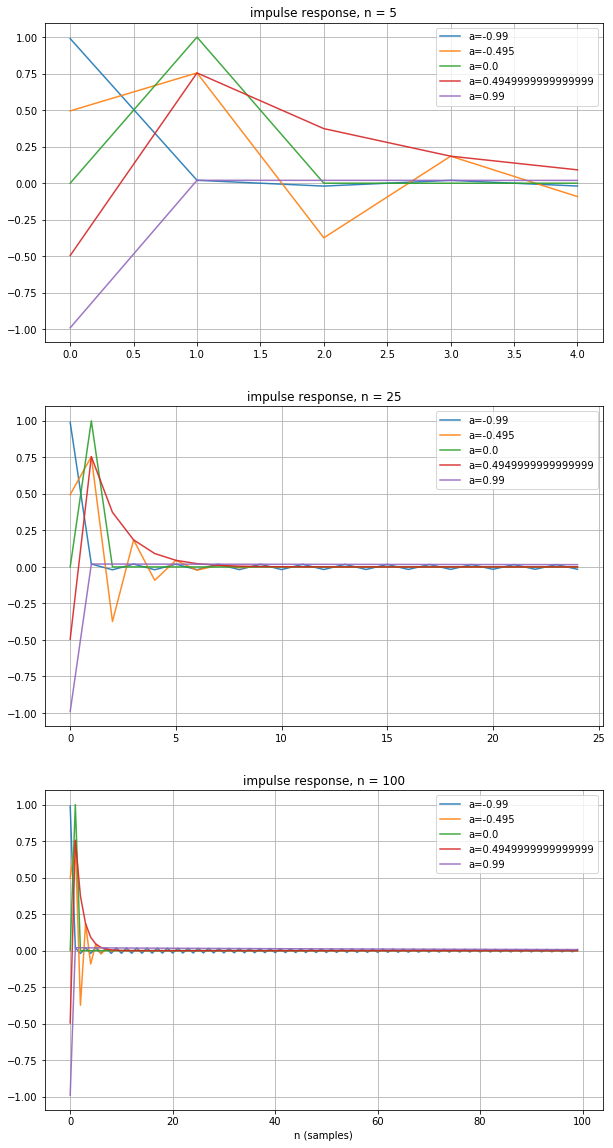

In [68]:
import matplotlib.pyplot as plt

warp_factors = numpy.linspace(-0.99, 0.99, 5)

fig1, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 20))
plt.xlabel('n (samples)')

for (ax, l) in [(ax1, 5), (ax2, 25), (ax3, 100)]:
    x_axis = numpy.arange(l)
    impulse = numpy.zeros(l); impulse[0] = 1.0
    ax.set_title('impulse response, n = {0}'.format(l))

    for i, wf in enumerate(warp_factors):
        impulse_response = scipy.signal.lfilter([-wf, 1.0], [1.0, -wf], impulse)
        ax.plot(x_axis, impulse_response, color='C{0}'.format(i), alpha=0.9, label='a={0}'.format(wf))
        ax.legend(loc='upper right')
        ax.grid()

fig.tight_layout()
plt.show()

## WFIR

Bringing it all together, we can define a function for a Kth-order WFIR (Warped Finite Impulse Response filter).

In [29]:
def wfir(x: numpy.ndarray, a: float, order: int) -> numpy.ndarray:
    B = [-a.conjugate(), 1]
    A = [1, -a]

    ys = [0] * order

    ys[0] = scipy.signal.lfilter(B, A, x)
    for i in range(1, len(ys)):
        ys[i] = scipy.signal.lfilter(B, A, ys[i - 1])
    
    return ys[-1]

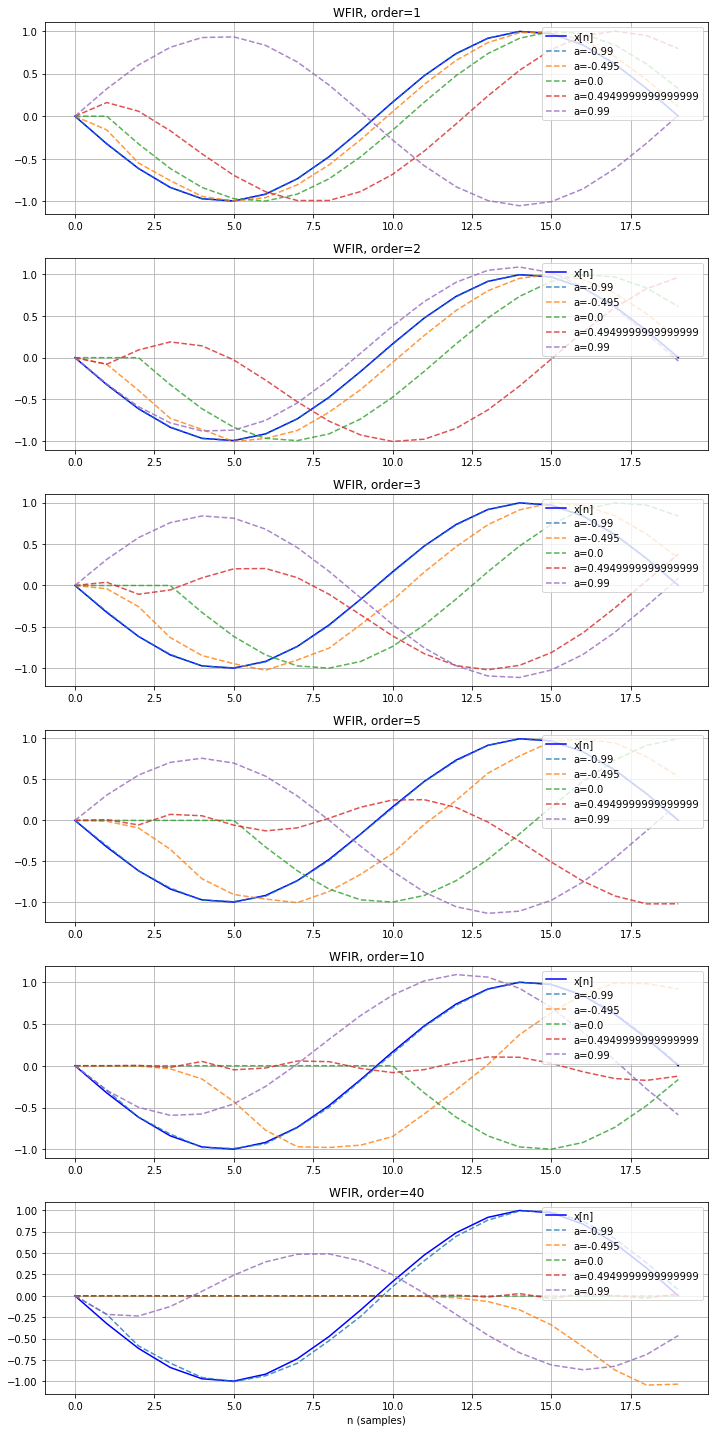

In [67]:
x = numpy.sin(numpy.linspace(-numpy.pi, numpy.pi, 20))
orders = [1, 2, 3, 5, 10, 40]
warp_factors = numpy.linspace(-0.99, 0.99, 5)

fig2, axes = plt.subplots(6, 1, figsize=(10, 20))
plt.title(r'WFIR, y[n] = $D(z)$x[n]')
plt.xlabel('n (samples)')

for i, ax in enumerate(axes):
    o = orders[i]
    ax.set_title('WFIR, order={0}'.format(o))
    ax.plot(samples, x, 'b', label='x[n]')
    for i, a in enumerate(warp_factors):
        y = wfir(x, a, o)
        samples = numpy.arange(max(len(x), len(y)))
        ax.plot(samples, y, color='C{0}'.format(i), linestyle='--', alpha=0.8, label='a={0}'.format(a))
        ax.legend(loc='upper right')
        ax.grid()

fig2.tight_layout()
plt.show()

Finally, let's look at the impulse response of higher-order WFIRs.

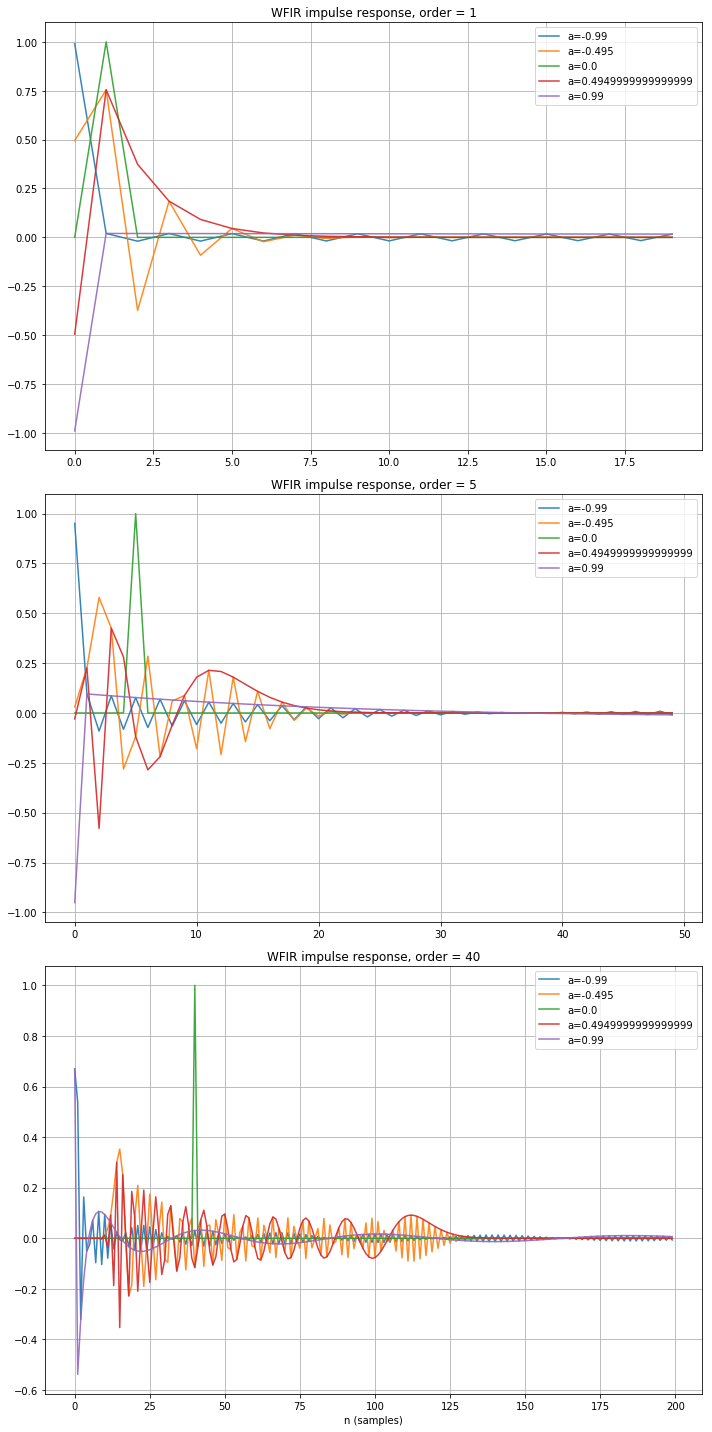

In [75]:
import matplotlib.pyplot as plt

warp_factors = numpy.linspace(-0.99, 0.99, 5)

fig3, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 20))
plt.xlabel('n (samples)')

for i, (ax, o, l) in enumerate([(ax1, 1, 20), (ax2, 5, 50), (ax3, 40, 200)]):
    x_axis = numpy.arange(l)
    impulse = numpy.zeros(l); impulse[0] = 1.0
    ax.set_title('WFIR impulse response, order = {0}'.format(o))

    for i, wf in enumerate(warp_factors):
        impulse_response = wfir(impulse, wf, o)
        ax.plot(x_axis, impulse_response, color='C{0}'.format(i), alpha=0.9, label='a={0}'.format(wf))
        ax.legend(loc='upper right')
        ax.grid()

fig3.tight_layout()
plt.show()

Note that the x-axis is longer for higher orders, i.e. the WFIR filter's impulse response is non-zero for more samples.

## References

1. Surges, Greg & Smyth, Tamara. (2013). "Spectral Distortion Using Second-Order Allpass Filters"

2. P. Kabal, "Minimum-phase & all-pass filters," Department of Electrical & Computer Engineering, McGill University, Tech. Rep., 2011.

3. P. A. Regalia, S. K. Mitra and P. P. Vaidyanathan, "The digital all-pass filter: a versatile signal processing building block," in Proceedings of the IEEE, vol. 76, no. 1, pp. 19-37, Jan. 1988. doi: 10.1109/5.3286

4. A. D. Simić and M. D. Lutovac, "New realizations of second-order all-pass transfer functions," 9th European Signal Processing Conference (EUSIPCO 1998), Rhodes, 1998, pp. 1-4.

5. Schuller G., "Frequency Warping, Example,", Digital Signal Processing 2/ Advanced Digital Signal Processing Lecture 10, TU-Ilmenau

6. Oppenheim A. V., Willsky A. S., Nawab S. H., "Signals & Systems Second Edition," Prentice Hall 1997